#**Demostração - Aula 3**

# **Análise de Tópicos**

<font size=5>
Análise, ou Modelagem, de Tópicos nos permite analisar grandes volumes de texto atravéz de técnicas de clusterização ou agrupamento dos documentos em tópicos!
<br/>
<br/>
Grande parte dos dados disponíveis no mundo real não estão classificados e por isso não podemos aplicar as técnicas de aprendizado supervisionado que usamos anteriormente!
<br/>
<br/>

Nestes casos, onde trabalhamos com dados não classificados, podemos tentar encontrar suas classificações agrupando-os em tópicos.

  </font>




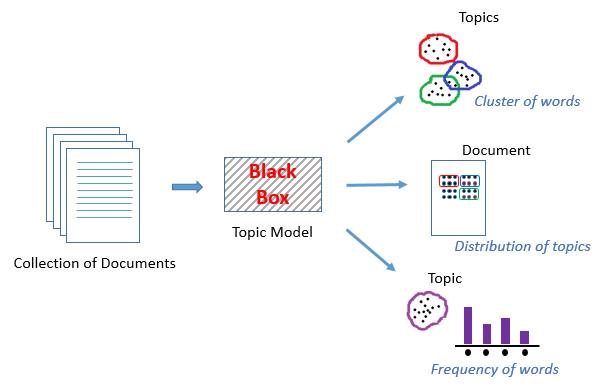

## **Importante!**

<font size=4>
Por não termos junto aos dados sua verdadeira classificação, nesses casos não sabemos a "resposta correta" o que torna muito difícil mensurar o quanto nosso algoritmo está acertando ou errando!
<br/>
<br/>

Tudo que sabemos (ou assumimos) é que documentos que forem agrupados no mesmo tópico compartilham ideias similares.
<br/>
<br/>

Fica a cargo do usuário (cientista/analista de dados, eng. machine learning e etc) se os grupos formados são coerentes e o que cada grupo representa!
</font>

# **LDA - Latent Dirichlet Allocation**

<font size=5>
LDA ou Latent Dirichlet Allocation é um “modelo probabilístico generativo” de uma coleção composta de partes. Em termos de modelagem de tópicos, as coleções são documentos e as partes são palavras, ou frases (n-gramas).  
<br/>
<br/>
O LDA tem esse nome pois usa a Distribuição Dirichlet (do matemático alemão Johann Peter Gustav Lejeune Dirichlet) para encontrar tópicos "latentes" nos documentos.
<br/>
<br/>
Em 2003, esse método foi publicado pela primeira vez por David Blei, Andrew Ng e Michael Jordan e pode ser
<a href="http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf">lido aqui</a>
<br/>
<br/>

Para entender melhor como o método funciona recomendo a leitura do artigo original no link acima!
  
</font>



## LDA

<font size=5>
Existem algumas premissas na aplicação do LDA:
<br/>
<br/>

1.   Documentos com assuntos similares usam palavras similares<br/>
2.   Os tópicos latentes podem ser encontrados atravez dos grupos de palavras que ocorrem juntas<br/>
3.   Documentos são distribuições de probabilidade sobre os tópicos latentes<br/>
4.   Tópicos são também distribuições de probabilidade sobre as palavras<br/>

</font>

## Documentos são distribuições de probabilidade sobre os tópicos latentes

![alt text](https://i.ibb.co/C2gs3mS/doc-prob-topics.png)

## Tópicos são também distribuições de probabilidade sobre as palavras

![alt text](https://i.ibb.co/KskDmbD/topic-prob-words.png)

## **Exemplo Análise de Tópicos**

In [1]:
import pandas as pd

df = pd.read_csv("https://dados-ml-pln.s3-sa-east-1.amazonaws.com/produtos.csv", delimiter=";", encoding='utf-8')

df.describe()

,nome,descricao,categoria
count,4080,2916,4080
unique,3696,2460,4
top,Boneco Dragon Ball Z Son Gokou,JOGO ORIGINAL. NOVO. LACRADO. PRONTA ENTREGA. ...,livro
freq,20,39,1020


In [2]:
df.dropna(inplace=True)

df["texto"] = df['nome'] + " " + df['descricao']

In [3]:
df.describe()

,nome,descricao,categoria,texto
count,2916,2916,2916,2916
unique,2584,2460,4,2646
top,Boneco Dragon Ball Z Son Gokou,JOGO ORIGINAL. NOVO. LACRADO. PRONTA ENTREGA. ...,livro,Boneco Dragon Ball Z Son Gokou Produto novo
freq,20,39,838,20


In [4]:
df.categoria.value_counts()

livro        838
maquiagem    788
brinquedo    668
game         622
Name: categoria, dtype: int64

In [5]:
# amostra
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df,
      test_size = 0.2,
      random_state = 42
  )

In [6]:
# stopwords do nltk
import nltk
nltk.download('stopwords')

stops = nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
# vetorização
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(ngram_range=(1,1), stop_words=stops)
vect.fit(df_train.texto)
text_vect_train = vect.transform(df_train.texto)

In [8]:
# treinamento do modelo
from sklearn.decomposition import LatentDirichletAllocation

LDA = LatentDirichletAllocation(n_components=4, random_state=42)
LDA.fit(text_vect_train)

LatentDirichletAllocation(n_components=4, random_state=42)

In [ ]:
#LDA.get_params()

In [11]:
LDA.components_.shape

(4, 31506)

In [12]:
LDA.components_[0]

array([20.37408976,  5.46762667,  0.25328679, ...,  0.25000302,
        5.34517087,  1.24878944])

In [13]:
LDA.components_[0].argsort()

array([11512, 15675, 26875, ..., 19932, 18447, 23485])

In [14]:
LDA.components_[0].argsort()[:15]

array([11512, 15675, 26875, 21606, 15221, 20935, 18622, 20156,  9015,
       30034, 27895, 14451, 30563, 15649, 20811])

In [15]:
vect.get_feature_names_out()[14451] #11526 #20811

'filter'

In [16]:
# top palavras dos tópicos
terms = vect.get_feature_names_out()

for index, topic in enumerate(LDA.components_):
    terms_comp = zip(terms, topic)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:15]
    print("THE TOP 15 WORDS FOR TOPIC # "+str(index)+": ")
    #print(sorted_terms)
    print([t[0] for t in sorted_terms])
    print('\n')

THE TOP 15 WORDS FOR TOPIC # 0: 
['pincel', 'kit', 'maquiagem', 'cores', 'produto', 'cm', 'profissional', 'maleta', 'base', 'sombra', 'matte', '01', 'pincéis', 'ruby', 'rose']


THE TOP 15 WORDS FOR TOPIC # 1: 
['produto', 'edição', 'livro', 'páginas', 'novo', 'vida', 'mundo', 'anos', 'história', '00', 'livros', 'origem', 'capa', 'sobre', 'série']


THE TOP 15 WORDS FOR TOPIC # 2: 
['cílios', 'harry', '12', 'potter', 'produto', 'kit', 'fio', 'super', 'produtos', 'compra', 'tamanho', 'postiços', 'frete', 'flex', 'pode']


THE TOP 15 WORDS FOR TOPIC # 3: 
['mercado', 'produto', 'pagamento', 'prazo', 'frete', 'entrega', 'envio', 'jogo', 'produtos', 'compra', 'dias', 'vendedor', 'comprar', 'anúncio', 'original']




In [ ]:
'''
0 - maquiagem
1 - livro
2 - brinquedo
3 - game
'''

In [ ]:
'''
for index, topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([vect.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')
'''

In [20]:
# aplica o modelo de analise de tópicos na base de teste
# vetorização
text_vect_test = vect.transform(df_test.texto)

# scoragem
results = LDA.transform(text_vect_test)

In [21]:
# contagem
print(text_vect_train.shape)
print(text_vect_test.shape)

print(text_vect_train.shape[0]+text_vect_test.shape[0])

(2332, 31506)
(584, 31506)
2916


In [22]:
results[0]

array([0.88342881, 0.02287574, 0.08830277, 0.00539267])

In [23]:
results.argmax(axis=1)

array([0, 0, 3, 0, 0, 1, 3, 1, 3, 3, 2, 1, 2, 1, 3, 3, 3, 3, 1, 2, 2, 1,
       3, 0, 3, 0, 1, 0, 0, 0, 3, 1, 1, 2, 3, 3, 2, 0, 0, 1, 1, 2, 3, 3,
       1, 3, 2, 0, 1, 1, 2, 1, 1, 2, 0, 1, 1, 2, 1, 2, 3, 3, 1, 1, 1, 1,
       0, 1, 2, 1, 1, 2, 1, 3, 1, 1, 1, 1, 3, 3, 3, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 3, 3, 0, 1, 2, 3, 2, 0, 2, 3, 2,
       0, 3, 3, 1, 2, 3, 3, 3, 3, 3, 3, 2, 1, 3, 3, 3, 3, 0, 3, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 3, 1, 3, 2, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 2,
       2, 3, 1, 1, 0, 2, 1, 1, 3, 0, 2, 2, 1, 3, 0, 1, 2, 3, 0, 1, 1, 0,
       0, 1, 3, 1, 1, 1, 0, 1, 3, 1, 1, 0, 1, 3, 3, 2, 1, 3, 1, 1, 1, 3,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 3, 2, 3, 0, 3, 0, 1,
       0, 0, 1, 2, 0, 2, 1, 1, 0, 3, 1, 1, 1, 2, 1, 3, 3, 3, 1, 1, 1, 3,
       0, 3, 1, 1, 0, 0, 1, 3, 3, 2, 1, 0, 0, 3, 0, 3, 0, 1, 1, 1, 2, 1,
       3, 3, 2, 1, 3, 0, 1, 0, 2, 0, 3, 3, 0, 1, 2, 3, 3, 3, 0, 1, 1, 1,
       3, 1, 1, 1, 1, 2, 2, 0, 1, 3, 1, 2, 1, 0, 3,

In [24]:
# seleciona o tópico com a maior probabilidade
df_test['topico'] = results.argmax(axis=1)

df_test.head()

,nome,descricao,categoria,texto,topico
2700,Estojo Duo Iluminador E Bronzer Belle Angel M...,DUO ILUMINADOR E BRONZER BELLE ANGEL - B025O D...,maquiagem,Estojo Duo Iluminador E Bronzer Belle Angel M...,0
1297,Patrulha Canina Carrinhos De Fricção 6 Person...,Kit carrinhos da Patrulha canina Tamanho: Cerc...,brinquedo,Patrulha Canina Carrinhos De Fricção 6 Person...,0
3162,Pokemon Ultra Moon Nintendo 3ds Midia Fisica ...,#Nossos produtos são NOVOS e 100% ORIGINAIS# ...,game,Pokemon Ultra Moon Nintendo 3ds Midia Fisica ...,3
2895,Kite Pincel 12 Unidade,esta alta qualidade Punho de madeira Escova Co...,maquiagem,Kite Pincel 12 Unidade esta alta qualidade ...,0
2226,Maleta Grande P/ Maquiagem Profissional Rodin...,FOTOS REAIS DO PRODUTO - ENVIAMOS SUA MALETA C...,maquiagem,Maleta Grande P/ Maquiagem Profissional Rodin...,0


In [25]:
# aplica de/para da classificação no dataframe
import numpy as np

df_test['categ_cod'] = df_test.categoria.map(
    {'maquiagem': 0, 'livro':1, 'brinquedo': 2, 'game': 3}
    )

'''
0 - maquiagem
1 - livro
2 - brinquedo
3 - game
'''

'\n0 - maquiagem\n1 - livro\n2 - brinquedo\n3 - game\n'

In [26]:
df_test.head()

,nome,descricao,categoria,texto,topico,categ_cod
2700,Estojo Duo Iluminador E Bronzer Belle Angel M...,DUO ILUMINADOR E BRONZER BELLE ANGEL - B025O D...,maquiagem,Estojo Duo Iluminador E Bronzer Belle Angel M...,0,0
1297,Patrulha Canina Carrinhos De Fricção 6 Person...,Kit carrinhos da Patrulha canina Tamanho: Cerc...,brinquedo,Patrulha Canina Carrinhos De Fricção 6 Person...,0,2
3162,Pokemon Ultra Moon Nintendo 3ds Midia Fisica ...,#Nossos produtos são NOVOS e 100% ORIGINAIS# ...,game,Pokemon Ultra Moon Nintendo 3ds Midia Fisica ...,3,3
2895,Kite Pincel 12 Unidade,esta alta qualidade Punho de madeira Escova Co...,maquiagem,Kite Pincel 12 Unidade esta alta qualidade ...,0,0
2226,Maleta Grande P/ Maquiagem Profissional Rodin...,FOTOS REAIS DO PRODUTO - ENVIAMOS SUA MALETA C...,maquiagem,Maleta Grande P/ Maquiagem Profissional Rodin...,0,0


In [27]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 584 entries, 2700 to 1842
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   nome       584 non-null    object
 1   descricao  584 non-null    object
 2   categoria  584 non-null    object
 3   texto      584 non-null    object
 4   topico     584 non-null    int64 
 5   categ_cod  584 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 31.9+ KB


In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix

print(accuracy_score(df_test.categ_cod, df_test.topico))

0.6575342465753424


<Axes: >

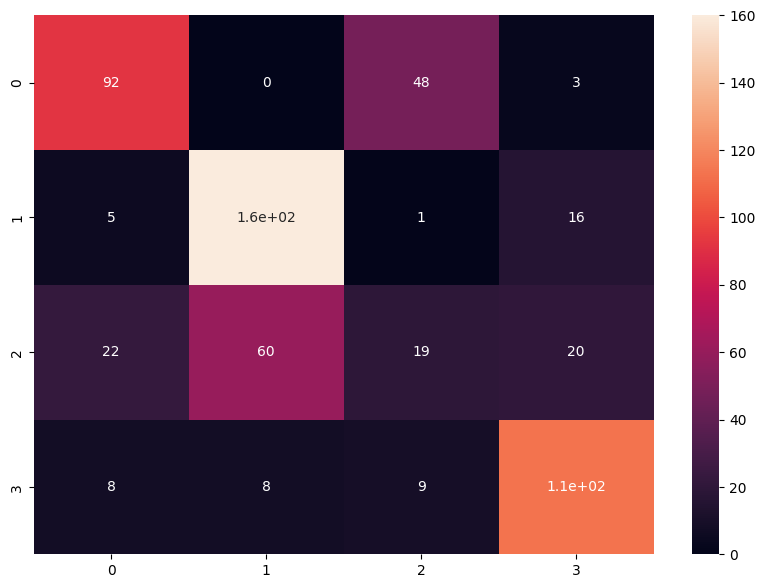

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

matrix = confusion_matrix(df_test.categ_cod, df_test.topico)

df_cm = pd.DataFrame(matrix, index=list('0123'),
                  columns=list('0123'))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

## ***Outros exemplos***

<font size=4>
<b>max_df:</b> float in range [0.0, 1.0] or int, default=1.0<br/>
When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.<br/>
Google T: Ao criar o vocabulário, ignore os termos que tenham uma frequência de documento estritamente maior que o limite fornecido (palavras de parada específicas do corpus). Se flutuante, o parâmetro representa uma proporção de documentos, número absoluto de contagens. Este parâmetro será ignorado se o vocabulário não for Nenhum.
<br/>
<br/>

<b>min_df:</b> float in range [0.0, 1.0] or int, default=1<br/>
When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.<br/>
Google T: Ao criar o vocabulário, ignore os termos que tenham uma frequência de documento estritamente menor que o limite especificado. Esse valor também é chamado de corte na literatura. Se flutuante, o parâmetro representa uma proporção de documentos, número absoluto de contagens. Este parâmetro será ignorado se o vocabulário não for Nenhum.
</font>

In [30]:
df_train
df_test

,nome,descricao,categoria,texto,topico,categ_cod
2700,Estojo Duo Iluminador E Bronzer Belle Angel M...,DUO ILUMINADOR E BRONZER BELLE ANGEL - B025O D...,maquiagem,Estojo Duo Iluminador E Bronzer Belle Angel M...,0,0
1297,Patrulha Canina Carrinhos De Fricção 6 Person...,Kit carrinhos da Patrulha canina Tamanho: Cerc...,brinquedo,Patrulha Canina Carrinhos De Fricção 6 Person...,0,2
3162,Pokemon Ultra Moon Nintendo 3ds Midia Fisica ...,#Nossos produtos são NOVOS e 100% ORIGINAIS# ...,game,Pokemon Ultra Moon Nintendo 3ds Midia Fisica ...,3,3
2895,Kite Pincel 12 Unidade,esta alta qualidade Punho de madeira Escova Co...,maquiagem,Kite Pincel 12 Unidade esta alta qualidade ...,0,0
2226,Maleta Grande P/ Maquiagem Profissional Rodin...,FOTOS REAIS DO PRODUTO - ENVIAMOS SUA MALETA C...,maquiagem,Maleta Grande P/ Maquiagem Profissional Rodin...,0,0
...,...,...,...,...,...,...
3058,Maleta Maquiagem 3d Jasmyne 105 Batons Sombra...,Maleta Jasmyne-32 sombras 3D ou matte-06 blush...,maquiagem,Maleta Maquiagem 3d Jasmyne 105 Batons Sombra...,0,0
3110,Cartão Presente Steam Gift Card R$ 200 Reais ...,.:: VOCÊ ESTÁ COMPRANDO COM A VR GAMERS ::.EST...,game,Cartão Presente Steam Gift Card R$ 200 Reais ...,3,3
1364,Kit Com 2 Pista Mágica Maluca Carros 3 Com Lu...,Pista Montável Relâmpago Mcqueen Jackson Storm...,brinquedo,Kit Com 2 Pista Mágica Maluca Carros 3 Com Lu...,0,2
641,Mais Escuro Cinquenta Tons Mais Escuros Pelos...,Sinopse:E L James revisita Cinquenta tons com ...,livro,Mais Escuro Cinquenta Tons Mais Escuros Pelos...,0,1


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

stops = nltk.corpus.stopwords.words('portuguese')

vect = TfidfVectorizer(ngram_range=(2,2), stop_words=stops, max_df=0.9, min_df=2)
vect.fit(df_train.texto)
text_vect_train = vect.transform(df_train.texto)

LDA2 = LatentDirichletAllocation(n_components=4,random_state=42)
LDA2.fit(text_vect_train)

LatentDirichletAllocation(n_components=4, random_state=42)

In [32]:
# top palavras dos tópicos
terms = vect.get_feature_names_out()

for index, topic in enumerate(LDA2.components_):
    terms_comp = zip(terms, topic)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:15]
    print("THE TOP 15 WORDS FOR TOPIC # "+str(index)+": ")
    #print(sorted_terms)
    print([t[0] for t in sorted_terms])
    print('\n')

THE TOP 15 WORDS FOR TOPIC # 0: 
['dragon ball', 'produto novo', '30 cm', 'harry potter', 'boneco dragon', 'delineador gel', 'luz led', 'código barras', 'son gokou', 'envio imediato', 'nacional código', 'origem nacional', 'novo físico', 'ed encadernação', 'ball son']


THE TOP 15 WORDS FOR TOPIC # 1: 
['pronta entrega', 'cabo madeira', 'mercado livre', 'call of', 'madeira cerdas', 'cílios postiços', 'of duty', 'garota calendário', 'cerdas macias', 'mia vai', 'cílios naturais', 'macias 19cm', 'duas partes', 'mídia digital', 'ruby rose']


THE TOP 15 WORDS FOR TOPIC # 2: 
['atacado wow', 'wow shop', 'vendemos atacado', 'frete produtos', 'produtos vendemos', '100 reaismandamos', 'entregafotos 100', 'original completo', 'aproximadamente 24', 'feito frete', 'reaismandamos aproximadamente', 'retirar endereço', 'ruby rose', 'vendedor combinar', 'combinar vendedor']


THE TOP 15 WORDS FOR TOPIC # 3: 
['mercado envios', 'mercado pago', 'prazo envio', 'prazo entrega', 'mercado livre', 'gta games

In [33]:
# aplica o modelo de analise de tópicos na base de teste
# vetorização
text_vect_test = vect.transform(df_test.texto)

# scoragem
results = LDA2.transform(text_vect_test)

In [38]:
df_test['topico'] = results.argmax(axis=1)

df_test['categ_cod'] = df_test.categoria.map(
   {'maquiagem': 0, 'brinquedo':1, 'game': 3, 'livro': 2}
)

df_test['categ_cod'] = df_test.categoria.map(
   {'maquiagem': 3, 'brinquedo':0, 'game': 1, 'livro': 2}
)



print(accuracy_score(df_test.categ_cod, df_test.topico))

0.3202054794520548


In [ ]:
#df_test['categ_cod'] = df_test.categ_cod.astype(np.int64)

<Axes: >

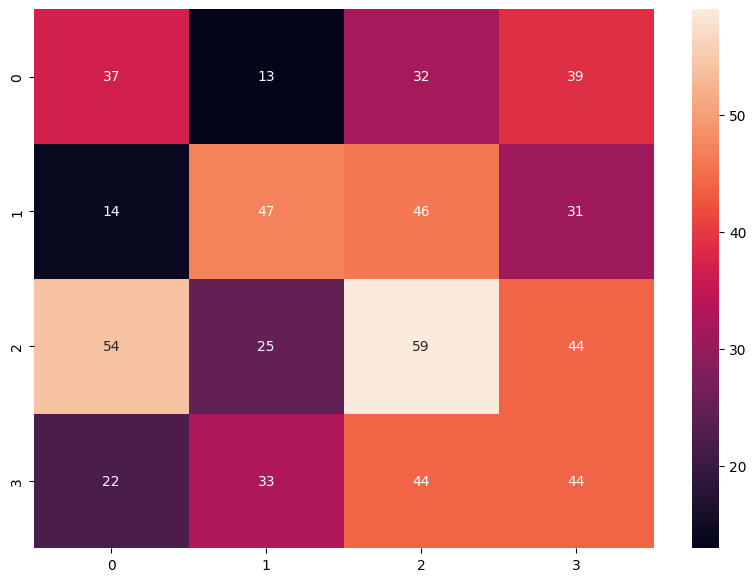

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

matrix = confusion_matrix(df_test.categ_cod, df_test.topico)

df_cm = pd.DataFrame(matrix, index=list('0123'),
                  columns=list('0123'))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

In [41]:
# Analisando com 8 tópicos
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

stops = nltk.corpus.stopwords.words('portuguese')

vect = TfidfVectorizer(ngram_range=(1,1), stop_words=stops)
vect.fit(df_train.texto)
text_vect_train = vect.transform(df_train.texto)

LDA3 = LatentDirichletAllocation(n_components=8,random_state=42)
LDA3.fit(text_vect_train)

LatentDirichletAllocation(n_components=8, random_state=42)

In [42]:
# top palavras dos tópicos
terms = vect.get_feature_names_out()

for index, topic in enumerate(LDA3.components_):
    terms_comp = zip(terms, topic)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:15]
    print("THE TOP 15 WORDS FOR TOPIC # "+str(index)+": ")
    #print(sorted_terms)
    print([t[0] for t in sorted_terms])
    print('\n')

THE TOP 15 WORDS FOR TOPIC # 0: 
['cílios', 'ana', 'vingadores', 'grey', 'luz', 'som', 'gokou', 'son', 'produto', 'novo', 'harry', 'christian', 'boneco', 'call', 'bonecos']


THE TOP 15 WORDS FOR TOPIC # 1: 
['edição', 'livro', 'livros', 'páginas', 'produto', '00', 'vida', 'história', 'kit', 'origem', 'mundo', 'anos', 'ed', 'capa', 'novo']


THE TOP 15 WORDS FOR TOPIC # 2: 
['flex', 'laminas', 'tebori', 'hard', 'fifa', 'jogadores', 'pula', 'fisica', 'agulhas', 'bola', 'pes', 'lista', 'pontas', 'português', 'lâmina']


THE TOP 15 WORDS FOR TOPIC # 3: 
['mia', 'gel', 'inglot', 'delineador', 'calendário', 'garota', 'págs', 'precisa', 'vai', 'tebori', 'produto', 'flexi', 'fica', 'kunai', 'mês']


THE TOP 15 WORDS FOR TOPIC # 4: 
['mercado', 'pincel', 'entrega', 'prazo', 'produto', 'cores', 'pagamento', 'produtos', 'maquiagem', 'kit', 'envio', 'maleta', 'pronta', 'dias', 'frete']


THE TOP 15 WORDS FOR TOPIC # 5: 
['miss', 'marrom', 'sobrancelha', 'prova', 'gel', 'rose', 'tatuagem', 'cartão

## ***Exercício***

Como já samemos, a base de dados de "produto" [1] foi utilizada para modelos de classificação supervisionados e sabemos qual foi a configuração que gerou um bom resultado. Que tal aplicarmos essas técnicas de pré-processamento que gerou um bom modelo e compararmos? Faça um teste de análise de tópicos com 4 tópicos conse as seguintes configurações:

*   Remover registros com valores nulos;
*   Contatenar as colunas de nome e descrição;
*   Aplicar lematização em verbos;
*   Amostra de 30% para teste e random_state = 42;
*   Vetorização de contagem dos termos em unigramas removendo stopwords (NLTK).

[1] https://dados-ml-pln.s3-sa-east-1.amazonaws.com/produtos.csv


In [ ]:
import pandas as pd

df = pd.read_csv("https://dados-ml-pln.s3-sa-east-1.amazonaws.com/produtos.csv", delimiter=";", encoding='utf-8')

In [ ]:
# respota

#***O que você achou da aula de hoje?***

Pelo aplicativo da FIAP ou pelo site

(Entrar no FIAP, e no menu clicar em Experience Survey)

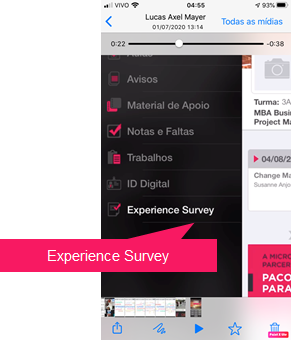